# 📧 Phishing Email Detection Using Machine Learning

**Project Author:** Bhargav Thakkar , Ankit Suthar  
 
**Technologies Used:** Python, Pandas, Scikit-learn, TF-IDF, Logistic Regression, Matplotlib, Seaborn

---

## 📋 Project Description

This project builds an end-to-end Machine Learning pipeline to detect phishing emails.  
The workflow includes:

- Data loading from multiple phishing datasets
- Text preprocessing (cleaning, normalization)
- Combining datasets into a unified DataFrame
- TF-IDF vectorization of email text
- Training a Logistic Regression classifier
- Model evaluation using Confusion Matrix, Precision-Recall Curve, ROC Curve
- Saving the trained model and vectorizer for future use

The final model achieves high accuracy and strong recall, making it suitable for real-world phishing detection systems.

---


# 📚 Table of Contents

1. [Load Raw Datasets and Add Source Column](#load-raw-datasets-and-add-source-column)
2. [Display Dataset Summary (Emails per Dataset)](#display-dataset-summary)
3. [Preprocess Text (Lowercase, Remove URLs, etc.)](#preprocess-text)
4. [Combine All Datasets into One Big DataFrame](#combine-all-datasets)
5. [Save Combined Dataset to CSV](#save-combined-dataset)
6. [Install Required Libraries (if missing)](#install-required-libraries)
7. [TF-IDF Vectorization and Train-Test Split](#tf-idf-vectorization-and-train-test-split)
8. [Save Vectorized Data and Splits](#save-vectorized-data-and-splits)
9. [Train Logistic Regression Model](#train-logistic-regression-model)
10. [Plot Confusion Matrix](#plot-confusion-matrix)
11. [Plot Precision-Recall Curve and ROC Curve](#plot-precision-recall-curve-and-roc-curve)
12. [Save Final Model and Vectorizer](#save-final-model-and-vectorizer)
13. [Project Summary](#project-summary)


📦 Cell 1: Load Raw Datasets and Add "Source" Column

In [23]:
import pandas as pd
import os

# Path where your raw datasets are stored
raw_data_path = r"C:\Users\Bhargav\ML model phising email\datasets"

# List of your raw dataset files
dataset_files = {
    'Assassin': 'Assassin.csv',
    'CEAS-08': 'CEAS-08.csv',
    'Enron': 'Enron.csv',
    'Ling': 'Ling.csv',
    'TREC-05': 'TREC-05.csv',
    'TREC-06': 'TREC-06.csv',
    'TREC-07': 'TREC-07.csv',
}

# Dictionary to hold loaded datasets
datasets = {}

# Step 1: Load each dataset and add 'source' column
for source_name, filename in dataset_files.items():
    file_path = os.path.join(raw_data_path, filename)
    print(f"Loading {filename}...")

    try:
        df = pd.read_csv(
            file_path,
            encoding='latin1',        # Handle weird characters
            on_bad_lines='skip'        # Skip badly formatted lines
        )
        
        # Add a new column called 'source'
        df['source'] = source_name
        
        # Store in dictionary
        datasets[source_name] = df

        print(f"{filename} loaded successfully. Shape: {df.shape}")

    except Exception as e:
        print(f"❌ Error loading {filename}: {e}")

print("\n✅ All datasets loaded (bad lines skipped if needed)!")


Loading Assassin.csv...
Assassin.csv loaded successfully. Shape: (5809, 8)
Loading CEAS-08.csv...
CEAS-08.csv loaded successfully. Shape: (39154, 8)
Loading Enron.csv...
Enron.csv loaded successfully. Shape: (29767, 4)
Loading Ling.csv...
Ling.csv loaded successfully. Shape: (2859, 4)
Loading TREC-05.csv...
❌ Error loading TREC-05.csv: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Loading TREC-06.csv...
❌ Error loading TREC-06.csv: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Loading TREC-07.csv...
TREC-07.csv loaded successfully. Shape: (53757, 8)

✅ All datasets loaded (bad lines skipped if needed)!


📊 Cell 1.1: Display Summary — Number of Emails Per Dataset

In [ ]:

summary = []

for name, df in datasets.items():
    summary.append({
        'Dataset': name,
        'Rows': df.shape[0],
        'Columns': df.shape[1]
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary)

# Display
print("📊 Dataset Summary:")
print(summary_df)

📊 Dataset Summary:
    Dataset   Rows  Columns
0  Assassin   5809        8
1   CEAS-08  39154        8
2     Enron  29767        4
3      Ling   2859        4
4   TREC-07  53757        8


🛠️ Cell 2: Preprocess Text (Lowercase, Remove URLs, Numbers, Punctuation)

In [25]:
# Cell 2: Preprocessing text inside each dataset

import re
import string

# Define a text cleaning function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing to each dataset
for source_name, df in datasets.items():
    # Let's assume your text is in a column called 'text' or maybe 'body' or 'content'
    # We'll find which column has the email content
    text_columns = [col for col in df.columns if 'subject' in col.lower() or 'body' in col.lower() or 'text' in col.lower() or 'content' in col.lower()]
    
    if not text_columns:
        print(f"⚠️ No text column found for {source_name}, skipping...")
        continue
    
    text_col = text_columns[0]  # pick the first matching one
    
    print(f"Preprocessing {source_name} using column: {text_col}")
    
    # Preprocess text
    df['text_cleaned'] = df[text_col].apply(preprocess_text)
    
    # Update back to dictionary
    datasets[source_name] = df

print("\n✅ Preprocessing complete for all datasets!")


Preprocessing Assassin using column: subject
Preprocessing CEAS-08 using column: subject
Preprocessing Enron using column: subject
Preprocessing Ling using column: subject
Preprocessing TREC-07 using column: subject

✅ Preprocessing complete for all datasets!


📦 Cell 3: Combine All Preprocessed Datasets into One Big DataFrame

In [26]:
# Cell 3: Combine all datasets into one big DataFrame

# List to collect all DataFrames
all_dataframes = []

for source_name, df in datasets.items():
    # Check if 'Label' exists; some datasets may call it differently
    label_columns = [col for col in df.columns if 'label' in col.lower() or 'spam' in col.lower() or 'class' in col.lower()]
    
    if not label_columns:
        print(f"⚠️ No label column found for {source_name}, skipping...")
        continue
    
    label_col = label_columns[0]  # pick first matching label column
    
    # Only select 'text_cleaned', 'Label', and 'source'
    temp_df = df[['text_cleaned', label_col, 'source']].copy()
    temp_df.columns = ['text', 'label', 'source']  # Rename for consistency
    
    all_dataframes.append(temp_df)

# Combine all into one
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Final Preview
print("\n✅ All datasets combined successfully!")
print(f"Combined dataset shape: {combined_df.shape}")
print("\nPreview of combined dataset:")
print(combined_df.head())



✅ All datasets combined successfully!
Combined dataset shape: (131346, 3)

Preview of combined dataset:
                                          text  label    source
0                      re new sequences window      0  Assassin
1                       zzzzteana re alexander      0  Assassin
2                      zzzzteana moscow bomber      0  Assassin
3            irr klez the virus that  wont die      0  Assassin
4  re zzzzteana nothing like mama used to make      0  Assassin


📊 Cell 3.1: Display Summary — Combined Dataset Preview and Shape

In [27]:
# Count number of rows from each source
source_counts = combined_df['source'].value_counts().reset_index()
source_counts.columns = ['Source', 'Number of Emails']

# Display
print("📊 Emails per Source Dataset:")
print(source_counts)

📊 Emails per Source Dataset:
     Source  Number of Emails
0   TREC-07             53757
1   CEAS-08             39154
2     Enron             29767
3  Assassin              5809
4      Ling              2859


💾 Cell 4: Save Combined Dataset to CSV

In [28]:
# Cell 4: Save the combined dataset

import os

# Define save path
save_folder = r"C:\Users\Bhargav\ML model phising email\Combined dataset"
save_path = os.path.join(save_folder, "combined_dataset.csv")

# Make sure directory exists
os.makedirs(save_folder, exist_ok=True)

# Save combined DataFrame
combined_df.to_csv(save_path, index=False)

print(f"✅ Combined dataset saved successfully at:\n{save_path}")
print(f"📦 Total rows saved: {combined_df.shape[0]}")


✅ Combined dataset saved successfully at:
C:\Users\Bhargav\ML model phising email\Combined dataset\combined_dataset.csv
📦 Total rows saved: 131346


⚙️ Cell 4.1: Install Required Libraries (If Missing)

In [30]:
# Cell 4.1: Install required libraries

!pip install scikit-learn


🔥 Cell 5: TF-IDF Vectorization and Train-Test Split

📁 Cell 5.1: Save Vectorized Data and Train/Test Splits

In [32]:
# Cell 5 (fixed): Load, Vectorize, Split, Save Vectorized Data

import pandas as pd
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load combined dataset
combined_path = r"C:\Users\Bhargav\ML model phising email\Combined dataset\combined_dataset.csv"
df = pd.read_csv(combined_path)

# Drop rows where 'text' is NaN or empty
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != '']

# Features and Labels
X_raw = df['text']
y = df['label']

# Create TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

# Fit and transform
X = tfidf.fit_transform(X_raw)

print("✅ TF-IDF vectorization complete!")
print(f"Shape of vectorized data: {X.shape}")

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Train-Test Split complete! Training size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Save Vectorized Data
vectorized_save_folder = r"C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data"
os.makedirs(vectorized_save_folder, exist_ok=True)

# Save TF-IDF Vectorizer
joblib.dump(tfidf, os.path.join(vectorized_save_folder, "tfidf_vectorizer.pkl"))

# Save Train and Test Data
joblib.dump(X_train, os.path.join(vectorized_save_folder, "X_train.pkl"))
joblib.dump(X_test, os.path.join(vectorized_save_folder, "X_test.pkl"))
joblib.dump(y_train, os.path.join(vectorized_save_folder, "y_train.pkl"))
joblib.dump(y_test, os.path.join(vectorized_save_folder, "y_test.pkl"))

print(f"✅ All vectorized data and splits saved successfully in:\n{vectorized_save_folder}")


✅ TF-IDF vectorization complete!
Shape of vectorized data: (130251, 5000)
✅ Train-Test Split complete! Training size: 104200, Test size: 26051
✅ All vectorized data and splits saved successfully in:
C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data


🧠 Cell 6: Train Logistic Regression Model and Save Model

In [33]:
# Cell 6: Train Logistic Regression Model

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Path where vectorized data is saved
vectorized_save_folder = r"C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data"

# Load vectorized data
X_train = joblib.load(os.path.join(vectorized_save_folder, "X_train.pkl"))
X_test = joblib.load(os.path.join(vectorized_save_folder, "X_test.pkl"))
y_train = joblib.load(os.path.join(vectorized_save_folder, "y_train.pkl"))
y_test = joblib.load(os.path.join(vectorized_save_folder, "y_test.pkl"))

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

print("✅ Logistic Regression Model Trained Successfully!")

# Predict on Test Set
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Test Accuracy: {accuracy:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save Trained Model
model_save_path = os.path.join(vectorized_save_folder, "logistic_regression_model.pkl")
joblib.dump(model, model_save_path)

print(f"\n✅ Trained model saved successfully at:\n{model_save_path}")


✅ Logistic Regression Model Trained Successfully!
📊 Test Accuracy: 0.9222

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     12772
           1       0.90      0.95      0.93     13279

    accuracy                           0.92     26051
   macro avg       0.92      0.92      0.92     26051
weighted avg       0.92      0.92      0.92     26051


✅ Trained model saved successfully at:
C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data\logistic_regression_model.pkl


📈 Cell 7: Plot Confusion Matrix

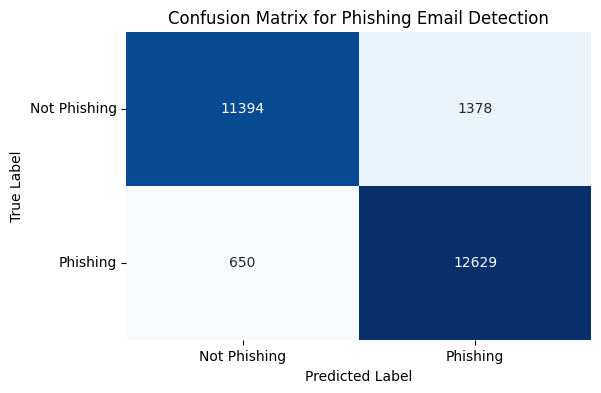

In [34]:
# Cell 7: Plot Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict again (just to make sure y_pred is fresh)
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix for Phishing Email Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.xticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'])
plt.yticks(ticks=[0.5, 1.5], labels=['Not Phishing', 'Phishing'], rotation=0)

plt.show()


📈 Cell 8: Plot Precision-Recall Curve and ROC Curve

c:\Users\Bhargav\anaconda3\envs\pyspark_home\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


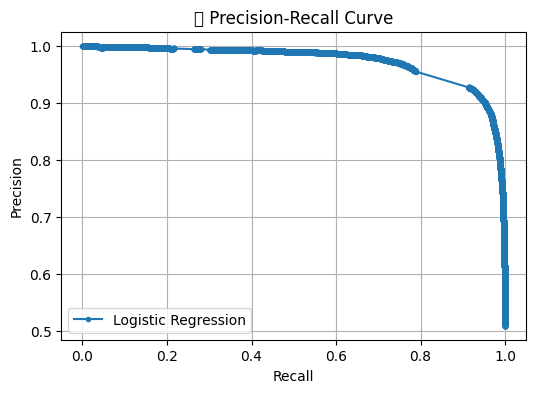

c:\Users\Bhargav\anaconda3\envs\pyspark_home\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


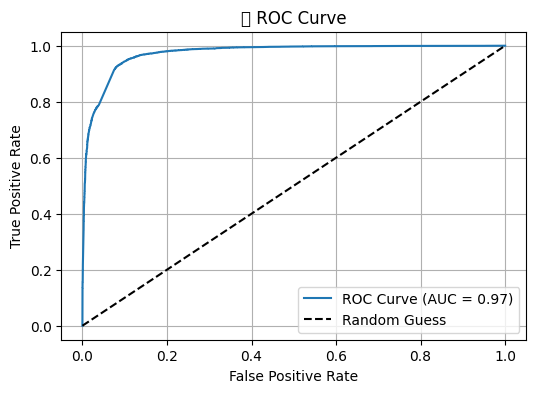

In [35]:
# Cell 8: Plot Precision-Recall Curve and ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1 (phishing)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.title('📈 Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('📈 ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()


In [36]:
# Final Cell: Save Model and Vectorizer

import joblib
import os

# Paths
vectorized_save_folder = r"C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data"

# Save Trained Model (again just to make sure it's there)
model_save_path = os.path.join(vectorized_save_folder, "logistic_regression_model.pkl")
joblib.dump(model, model_save_path)

# Save TF-IDF Vectorizer (already saved earlier but reconfirming)
tfidf_save_path = os.path.join(vectorized_save_folder, "tfidf_vectorizer.pkl")
joblib.dump(tfidf, tfidf_save_path)

print(f"✅ Logistic Regression model saved at: {model_save_path}")
print(f"✅ TF-IDF Vectorizer saved at: {tfidf_save_path}")


✅ Logistic Regression model saved at: C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data\logistic_regression_model.pkl
✅ TF-IDF Vectorizer saved at: C:\Users\Bhargav\ML model phising email\Combined dataset\vectorized data\tfidf_vectorizer.pkl
